# Task 2

#### To process Natural Language data I chose NLTK

NLTK is a suite of libraries and programs for symbolic and statistical natural language processing

In [1]:
import nltk

In [2]:
nltk.download_shell()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Unzipping corpora/stopwords.zip.



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


In [5]:
import pandas as pd

In [6]:
headlines = pd.read_json('/home/bartek/Documents/ROCHE_zadanie/rochepolskajuniordatascience/Graduate - HEADLINES dataset (2019-06).json', lines = True)

#### I check what is the structure of dataset

In [27]:
headlines.head(10)

,headline,is_sarcastic,length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64
5,advancing the world's women,0,27
6,the fascinating case for eating lab-grown meat,0,46
7,"this ceo will send your kids to school, if you...",0,67
8,top snake handler leaves sinking huckabee camp...,1,50
9,friday's morning email: inside trump's presser...,0,59


#### I check what are the lengths of the headlines

In [8]:
headlines['length'] = headlines['headline'].apply(len)
headlines.head()

,headline,is_sarcastic,length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64


#### The lengths of headlines are similar bewteen two classes

In [93]:
headlines.groupby('is_sarcastic').describe()

length                                                    
                count       mean        std  min   25%   50%   75%    max
is_sarcastic                                                             
0             14985.0  59.558625  17.318876  7.0  48.0  61.0  71.0  228.0
1             11724.0  62.638605  21.208409  8.0  48.0  61.0  76.0  254.0

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

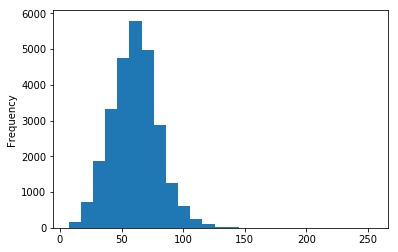

In [10]:
headlines['length'].plot(bins=25, kind='hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3dcf28ff98>,
      dtype=object)

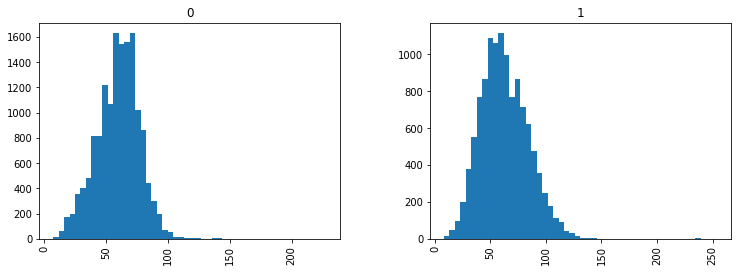

In [11]:
headlines.hist(column='length', by='is_sarcastic', bins=50,figsize=(12,4))

In [12]:
import string

#### I write a function that later will be used to process the text to make it suitable for the model 

In [15]:
from nltk.corpus import stopwords

In [13]:
def headlines_cleaning(hl):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # 1
    bez_interp = [char for char in hl if char not in string.punctuation]
    bez_interp = ''.join(bez_interp)
    
    # 2 and 3
    return [word for word in bez_interp.split() if word.lower() not in stopwords.words('english')]

#### I check if the function works properly

In [90]:
headlines.head(10)

,headline,is_sarcastic,length
0,former versace store clerk sues over secret 'b...,0,78
1,the 'roseanne' revival catches up to our thorn...,0,84
2,mom starting to fear son's web series closest ...,1,79
3,"boehner just wants wife to listen, not come up...",1,84
4,j.k. rowling wishes snape happy birthday in th...,0,64
5,advancing the world's women,0,27
6,the fascinating case for eating lab-grown meat,0,46
7,"this ceo will send your kids to school, if you...",0,67
8,top snake handler leaves sinking huckabee camp...,1,50
9,friday's morning email: inside trump's presser...,0,59


In [88]:
headlines['headline'].head(10).apply(headlines_cleaning)

0    [former, versace, store, clerk, sues, secret, ...
1    [roseanne, revival, catches, thorny, political...
2    [mom, starting, fear, sons, web, series, close...
3    [boehner, wants, wife, listen, come, alternati...
4    [jk, rowling, wishes, snape, happy, birthday, ...
5                           [advancing, worlds, women]
6          [fascinating, case, eating, labgrown, meat]
7             [ceo, send, kids, school, work, company]
8    [top, snake, handler, leaves, sinking, huckabe...
9    [fridays, morning, email, inside, trumps, pres...
Name: headline, dtype: object

#### Now I start vectorization of the the headlines

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

#### I transform the headlines column into matrix. 
Columns are the rows with headlines and the rows are number of counts of every word in the document - 
#### 26709 columns (number of headlines) and 28285 rows (number of unique words used)

In [94]:
bow_transformer = CountVectorizer(analyzer=headlines_cleaning).fit(headlines['headline'])

In [95]:
print(len(bow_transformer.vocabulary_))

28285


In [97]:
headlines_bow = bow_transformer.transform(headlines['headline'])

In [98]:
print('Shape of Sparse Matrix: ', headlines_bow.shape)
print('Amount of Non-Zero occurences: ', headlines_bow.nnz)

Shape of Sparse Matrix:  (26709, 28285)
Amount of Non-Zero occurences:  189039


#### Now I'm gonna count TF: Term Frequency and IDF: Inverse Document Frequency

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

In [99]:
from sklearn.feature_extraction.text import TfidfTransformer


In [100]:
tfidf_transformer = TfidfTransformer().fit(headlines_bow)


In [87]:
headlines_tfidf = tfidf_transformer.transform(headlines_bow)
print(headlines_tfidf.shape)

(26709, 28285)


#### Having the Natural language text processed into matrix of values I can prepare the model of binary classification

In [102]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

#### I split the independent and dependent values into training and testing sets

In [85]:
x_train, x_test, y_train, y_test = train_test_split(headlines['headline'], headlines['is_sarcastic'], test_size=0.2)

Which makes it more suitable for this task

#### I create a pipeline so I can put all the NLP techniques I used into one set

I decide to check 2 different models that offer binary classification.
When interpreting the metrics I want the f1 score to be biggest,
I want to distinguish the sarcastic values from the non-sarcastic.

In [103]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=headlines_cleaning)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', MultinomialNB()),  
    ])

In [104]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function headlines_cleaning at 0x7f3dcf4b4c80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [105]:
predictions = pipeline.predict(x_test)

In [106]:
from sklearn.metrics import classification_report
print (classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      3534
           1       0.65      0.84      0.73      1808

    accuracy                           0.79      5342
   macro avg       0.78      0.80      0.78      5342
weighted avg       0.82      0.79      0.80      5342



In [107]:
from sklearn.linear_model import LogisticRegression

In [109]:
pipeline2 = Pipeline([
    ('bow', CountVectorizer(analyzer=headlines_cleaning)),  
    ('tfidf', TfidfTransformer()),  
    ('classifier', LogisticRegression()),  
    ])

In [111]:
pipeline2.fit(x_train, y_train)

/home/bartek/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function headlines_cleaning at 0x7f3dcf4b4c80>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\...
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                            

In [114]:
predictions2 = pipeline2.predict(x_test)

In [68]:
print(classification_report(predictions2,y_test))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      3336
           1       0.70      0.82      0.75      2006

    accuracy                           0.80      5342
   macro avg       0.79      0.80      0.79      5342
weighted avg       0.81      0.80      0.80      5342



#### The LogisticRegression model have slightly better f1-scores values than MultinomialNB one.